# Assignment 3

##### INF412: Data Analytics - Informed Decisions with Data 
Luca Carnegie

In [30]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import statsmodels.api as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro

#### 1. Multiple Linear Regression (6 points)
The Winequality dataset (‘winequality.csv’) contains physicochemical properties of white wine
samples and their corresponding quality ratings. The columns and their descriptions are at below.

| Feature Name | Description |
|-------------|-------------|
| fixed acidity | The amount of non-volatile acids in wine (e.g., tartaric acid). Affects wine's taste and stability. |
| volatile acidity | The amount of acetic acid in wine. High values may lead to an unpleasant vinegar taste. |
| citric acid | A natural preservative found in wine, adding freshness and reducing oxidation. |
| residual sugar | The sugar left after fermentation. Affects sweetness; wines with high values are sweeter. |
| chlorides | The amount of salt in wine. Higher values may contribute to a salty taste. |
| free sulfur dioxide | The SO₂ available in wine to prevent microbial growth and oxidation. |
| total sulfur dioxide | The total SO₂ present (bound + free). Excessive levels can cause undesirable aromas. |
| density | The wine's mass per unit volume, influenced by sugar, alcohol, and other dissolved substances. |
| pH | The measure of acidity or alkalinity. Lower values indicate higher acidity. |
| sulphates | A compound that contributes to wine preservation and enhances bitterness. |
| alcohol | The ethanol content in wine (%). Affects body, aroma, and overall sensory experience. |
| quality | Wine quality score (integer from 3 to 9) based on sensory analysis by wine tasters. |

##### Load and Explore the Dataset

In [ ]:
# Load the dataset into a Pandas DataFrame. 
wine = pd.read_csv('winequality.csv')

# Display the first five rows, column names, and data types
print("\n===== FIRST 5 ROWS OF THE DATASET =====")
print(wine.head(5))

print("\n===== COLUMN NAMES =====")
for i, col in enumerate(wine.columns):
    print(f"{i+1}. {col}")

print("\n===== DATA TYPES =====")
dtypes_df = pd.DataFrame(wine.dtypes, columns=['Data Type'])
dtypes_df.index.name = 'Column'
print(dtypes_df)

# Display basic dataset dimensions
print(f"\n===== DATASET DIMENSIONS =====")
print(f"Number of samples: {wine.shape[0]}")
print(f"Number of features: {wine.shape[1]}")


===== FIRST 5 ROWS OF THE DATASET =====
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1

In [46]:
# Print summary statistics
print("\n===== COVARIATE SUMMARY STATISTICS =====")
print(wine.describe().transpose().round(2))


===== COVARIATE SUMMARY STATISTICS =====
                       count    mean    std   min     25%     50%     75%  \
Column                                                                      
fixed acidity         4898.0    6.85   0.84  3.80    6.30    6.80    7.30   
volatile acidity      4898.0    0.28   0.10  0.08    0.21    0.26    0.32   
citric acid           4898.0    0.33   0.12  0.00    0.27    0.32    0.39   
residual sugar        4898.0    6.39   5.07  0.60    1.70    5.20    9.90   
chlorides             4898.0    0.05   0.02  0.01    0.04    0.04    0.05   
free sulfur dioxide   4898.0   35.31  17.01  2.00   23.00   34.00   46.00   
total sulfur dioxide  4898.0  138.36  42.50  9.00  108.00  134.00  167.00   
density               4898.0    0.99   0.00  0.99    0.99    0.99    1.00   
pH                    4898.0    3.19   0.15  2.72    3.09    3.18    3.28   
sulphates             4898.0    0.49   0.11  0.22    0.41    0.47    0.55   
alcohol               4898.0   10.

In [33]:
# Identify and handle missing values (if any)
print(wine.isnull().sum())

Column
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


It appears that there are no missing values, which makes our life easy.

<Axes: xlabel='Column', ylabel='Column'>

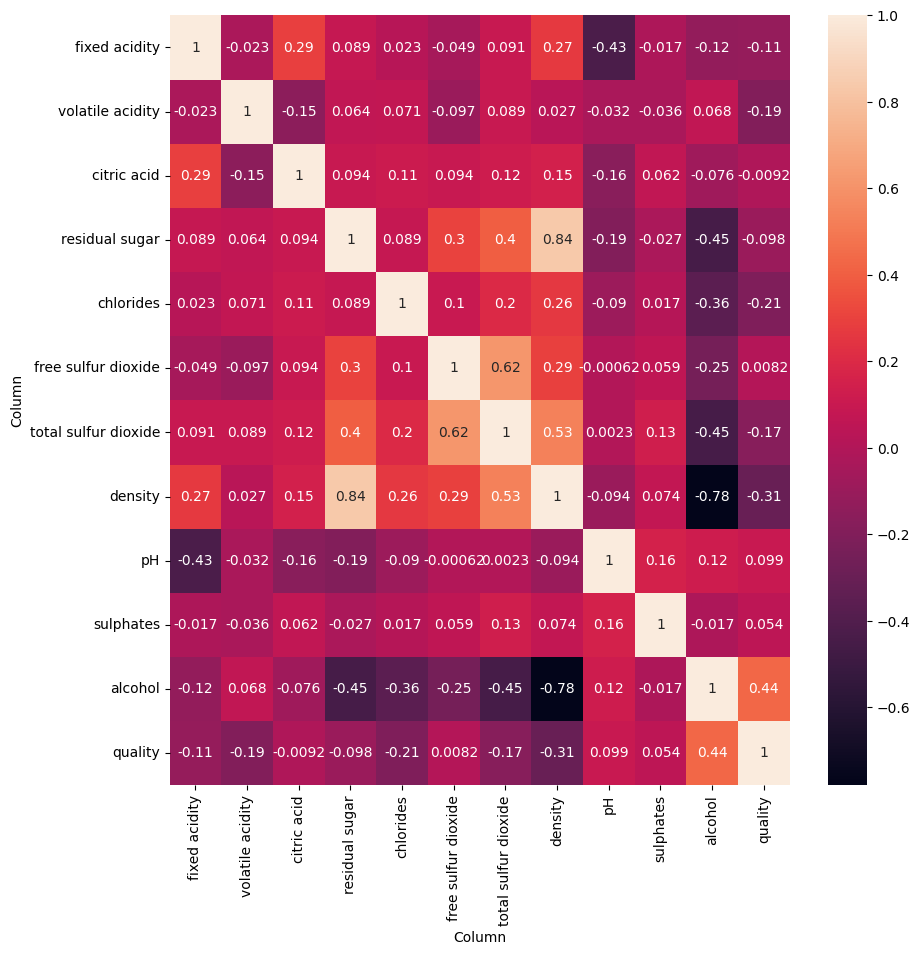

In [47]:
# Compute the correlation matrix between variables and create visualization with seaborn.
corr_matrix = wine.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True)

Looking at the variable descriptions and the correlation matrix, we can see a few preliminary relationships between certain variables, from positive to negative. We'll say that for a correlation between variables to be 'significant', it should be above 0.5 (i.e. at least 50% of the variance in one variable is explained by the other)

**Positive:**
1. There is a large positive relationship between **density** and **residual sugar** (+0.84), which makes sense since sugar left in the wine would increase it's g/mL. 
2. There is a decent positive relationship between **free sulfur dioxide** and **total sulfer dioxide** (+0.62)
3. There is a decent positive relationship between **total sulfur dioxide** and **density** (+0.53)

**Negative:**
1. There is a large negative relationship (-0.78) between **alcohol** and **density**

##### Performing Multiple Linear Regression (MLR)

Identify independent (X) and dependent (y) variables:
- **Our goal:** find what factors affect the variable 'quality'
- **Dependent variable:** quality
- **Independent variables:** fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol

**Assumption Checks**

In [35]:
# Split the dataset into training (80%) and testing (20%) subsets.

# Shuffle rows (to remove problems, if any, due to ordering)
wine = wine.sample(frac=1).reset_index(drop=True)

# Split the dataset into features and target variable
Y = wine['quality']
X = wine.drop('quality', axis=1)

# Split the dataset into training (80%) and testing (20%) subsets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [36]:
# train a linear regression model with sci-kit-learn
model = LinearRegression()
lin_reg = model.fit(X_train, Y_train)

# Model summary
## Coefficients
coefficients = model.coef_
intercept = model.intercept_
summary = pd.DataFrame(coefficients, index=X.columns, columns=['Coefficient'])
summary.loc['Intercept'] = intercept

# Evaluation Metrics (on train and test data)
r2_train = metrics.r2_score(Y_train, model.predict(X_train))
r2_test = metrics.r2_score(Y_test, model.predict(X_test))

mse_train = metrics.mean_squared_error(Y_train, model.predict(X_train))
mse_test = metrics.mean_squared_error(Y_test, model.predict(X_test))

rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
metrics_df = pd.DataFrame({'R^2': [r2_train, r2_test], 'MSE': [mse_train, mse_test], 'RMSE': [rmse_train, rmse_test]}, index=['Train', 'Test'])

print("\n===== MODEL SUMMARY =====")
print(summary.round(3))
print("\n===== EVALUATION METRICS =====")
print(metrics_df.round(3))


===== MODEL SUMMARY =====
                      Coefficient
Column                           
fixed acidity               0.067
volatile acidity           -1.920
citric acid                 0.060
residual sugar              0.077
chlorides                  -0.183
free sulfur dioxide         0.003
total sulfur dioxide       -0.000
density                  -137.576
pH                          0.651
sulphates                   0.593
alcohol                     0.203
Intercept                 137.595

===== EVALUATION METRICS =====
         R^2    MSE   RMSE
Train  0.276  0.565  0.752
Test   0.299  0.558  0.747


Interpreting the values of the model's adjusted R^2, on the training and test data, we can conclude that the current model covariates don't fit the data particularly well. We see this in the adjusted R-squared of 0.282 (train), which means that about 28% of the variance in the data is explained by the model itself. That said, when testing the model on new data (test), we get an R-squared of a similar magnitude, 0.280, meaning the model does generalize fairly well to new data it was not fitted on. That still does not negate the model's unsatisfactory explanatory power.  

This conclusion is also corroborated in the squared errors. Given the root mean squared error of 0.747 (test), it means that on average, the predictions of quality score (ranging from 3 to 9) for new data, based on the predictors, is off by an average of 0.747 score units or 12.5%. One explanation for this poor predictive power is that "wine quality" is very subjective, particularly since the scores in the dataset were judged by human tasters - one taster's score of "4" could means another taster's "5", or similar. Therefore, a high amount of scatter in wine quality is to be expected.

**Assumption Checks**

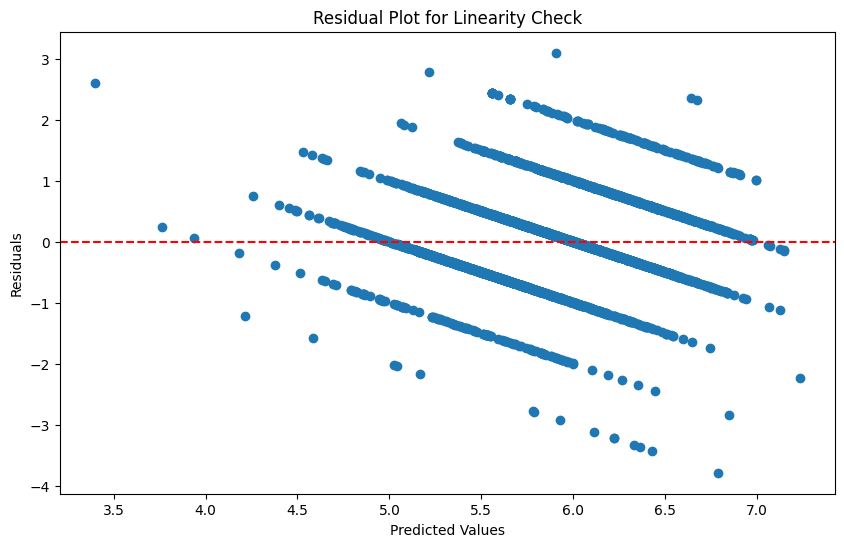

In [37]:
# Compute residuals
Y_pred_train = model.predict(X_train)
residuals = Y_train - Y_pred_train

# 1. Linearity Check - Residual Plot
plt.figure(figsize=(10, 6))
plt.scatter(Y_pred_train, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Linearity Check')
plt.show()

This unusual plot of the residuals show how the wine quality training data is discrete (from 3 to 9, with no values in between), but are being treated as continuous when an OLS regression is run. This is commonly observed when modeling ordinal data (like the wine quality ratings) with linear regression instead of using more appropriate methods like classification.

In [38]:
# 2. Multicollinearity Check - VIF

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Predictor"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

print("Variance Inflation Factors:")
print(vif_data.sort_values("VIF", ascending=False).round(2))

Variance Inflation Factors:
               Predictor      VIF
7                density  1035.11
8                     pH   600.95
10               alcohol   117.96
0          fixed acidity    92.98
6   total sulfur dioxide    25.04
9              sulphates    20.13
2            citric acid    10.00
1       volatile acidity     9.56
5    free sulfur dioxide     9.02
4              chlorides     6.44
3         residual sugar     3.70


Based on the output, density, pH, alcohol, fixed acidity, total sulfur dioxide, and sulphates exhibit significant multicollinearity with VIF values above the commonly accepted threshold of 5. Density has an extremely high VIF of 1048.93, followed by pH at 610.31 and alcohol at 118.79, indicating these three features are highly correlated with other variables in the dataset. The substantial multicollinearity among these chemical properties suggests they likely measure related aspects of the wine composition, which could lead to unstable coefficient estimates and reduced reliability in subsequent statistical modeling.

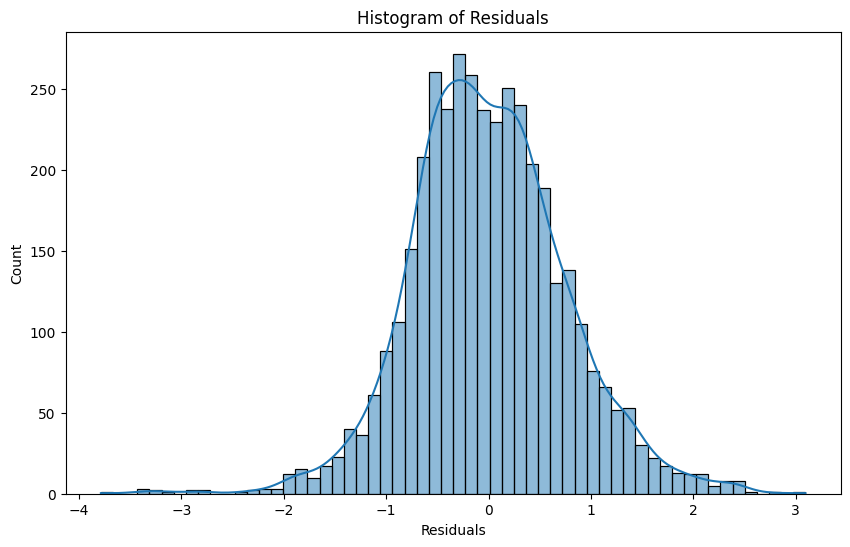

In [39]:
# 3. Normality of Residuals
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.show()

Residuals look about normally distributed when put in a histogram format.

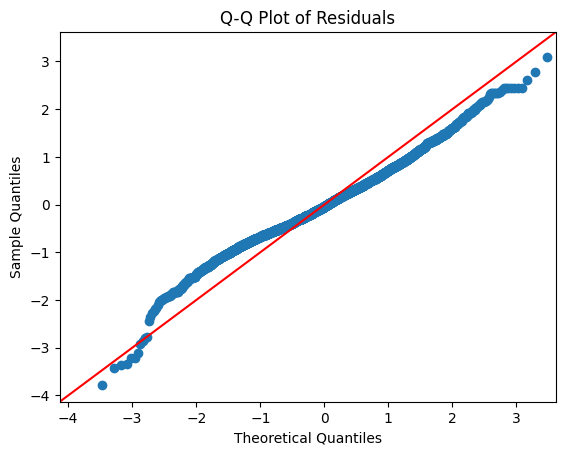


===== SHAPIRO-WILK TEST =====
Test Statistic: 0.99
P-value: 0.0


In [40]:
# Q-Q Plot
stats.qqplot(residuals, line="45")
plt.title("Q-Q Plot of Residuals")
plt.show()

# Shapiro-Wilk Test
shapiro_test = shapiro(residuals)
print("\n===== SHAPIRO-WILK TEST =====")
print(f"Test Statistic: {shapiro_test[0].round(3)}")
print(f"P-value: {shapiro_test[1].round(5)}")

Given the large deviation of most of the collected data quantiles from "normal" quantiles, we can quite easily say that residuals of this data are not very normally distributed. This is further corroborated with doing a Shapiro-Wilk test, which, given the data, comes to the same conclusion - this data is not normally distributed. 

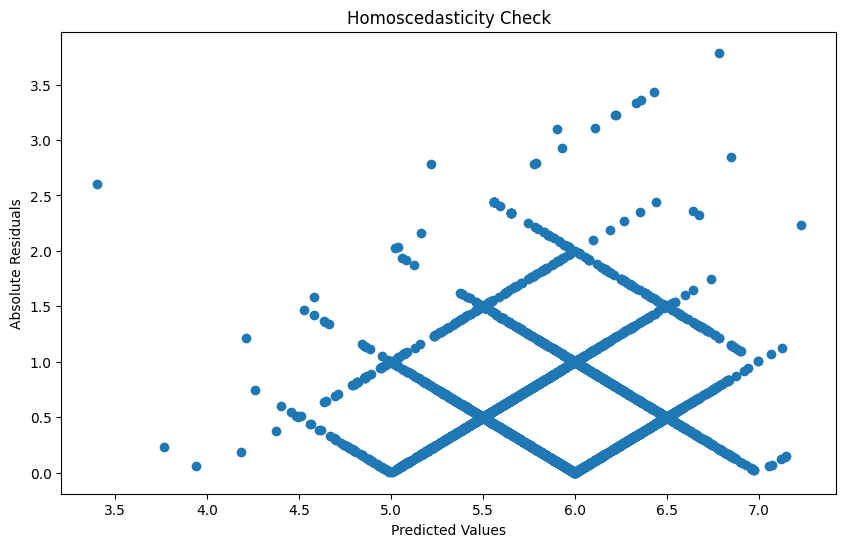

In [41]:
# 4. Homoscedasticity Check
plt.figure(figsize=(10, 6))
plt.scatter(Y_pred_train, np.abs(residuals))
plt.xlabel('Predicted Values')
plt.ylabel('Absolute Residuals')
plt.title('Homoscedasticity Check')
plt.show()

Similar to the linearity check plot, this unusual residual plot with distinct diamond-shaped patterns suggests the data comes from a discrete or categorical dependent variable that's being treated as continuous in a regression model. The diamond patterns form because the absolute residuals can only take certain specific values - when you predict a continuous value for something that can only be integers or fixed categories (like ratings on a 1-7 scale), the residuals follow these geometric patterns. This is typically observed when modeling ordinal data (like the wine quality ratings) with linear regression instead of using more appropriate methods like classification. 

The horizontal lines at specific residual values indicate the quantization effect where predictions can only be wrong by certain amounts because the actual values are restricted to specific levels. This plot suggests our modelling strategy should be majorly reconsidered with this dataset.

#### 2. Data Wrangling (4 points)
Use the data set 'camera dataset.csv'. This dataset features 1038 cameras with 9 properties
respectively. Please proceed with the data preparation.

In [42]:
camera = pd.read_csv('camera.csv')

##### Task 1

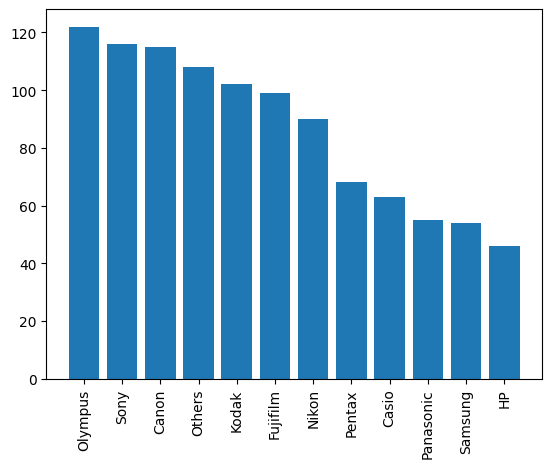

In [43]:
# Name all brands that are lower than 3% in number of models as one category "others"

# 1. extract the brand names from model column
camera["brand"] = camera["Model"].str.split().str[0]

# 2. count the number of models for each brand
brand_counts = camera["brand"].value_counts(normalize=True)

# 3. create a list of brands that make up lower than 3% of all models
other_brands = brand_counts[brand_counts < 0.03].index

# 4. replace the brand names with "others" for the brands in the list
camera["brand"] = camera["brand"].replace(other_brands, "Others")

# Use this revised dataset to develop a bar chart to show the counts of models by brand.
plt.bar(camera["brand"].value_counts().index, camera["brand"].value_counts().values)
plt.xticks(rotation=90)
plt.show()

In [44]:
'''
Calculate and report the mean and standard deviation values for the 'Max.resolution',
'Low.resolution', 'Zoom wide (W)' , and 'Zoom Tele (T)' columns within each year
('Release.date'). You can only use "groupby" and "agg" function, and the calculation
should be written a single line of code.'
'''

camera.groupby('Release date').agg(
    {
        'Max resolution': ['mean', 'std'], 
        'Low resolution': ['mean', 'std'], 
        'Zoom wide (W)': ['mean', 'std'], 
        'Zoom tele (T)': ['mean', 'std']
    }
).round(decimals=2) 

Max resolution         Low resolution         Zoom wide (W)  \
                       mean     std           mean     std          mean   
Release date                                                               
1994                1524.00     NaN           0.00     NaN          0.00   
1995                3060.00     NaN           0.00     NaN          0.00   
1996                 784.00  183.83         448.00  156.77         42.25   
1997                 849.45  282.02         378.18  279.64         41.64   
1998                1282.50  387.47         546.00  222.29         31.88   
1999                1470.34  353.03         716.08  307.08         33.51   
2000                1796.59  428.05        1049.90  450.12         34.05   
2001                1866.65  469.17        1116.61  503.31         34.65   
2002                2095.60  591.02        1390.76  558.35         33.98   
2003                2263.73  447.53        1484.65  635.36         33.64   
2004                2535.04  601.48        1836.51  655.73         32.89   
2005                2754.68  395.64        2180.77  531.15         32.62   
2006                3017.46  398.94        2409.73  400.51         30.93   
2007                3289.84  402.98        2501.84  692.97         32.61   

                    Zoom tele (T)          
                std          mean     std  
Release date                               
1994            NaN          0.00     NaN  
1995            NaN          0.00     NaN  
1996           7.32         57.00   33.33  
1997           5.71         70.73   40.65  
1998          10.86         86.50  106.35  
1999          10.15         89.21   73.79  
2000           9.56        111.79   89.77  
2001           9.34        104.95   84.30  
2002           9.41        105.85   73.65  
2003           8.82        118.19   84.04  
2004          10.02        123.51   89.17  
2005           9.96        130.20   96.21  
2006          12.44        134.65  102.70  
2007          10.14        146.68  103.83

##### Task 2

In [45]:
# For every column that is numerical type, keep only the rows where the condition
# value > 30 is satisfied.

# Get numerical columns
numerical_columns = camera.select_dtypes(include=['int', 'float']).columns

# Keep rows where numerical columns only have values > 30
camera = camera[camera[numerical_columns].gt(30).all(axis=1)]

# Filter rows with values > 30 only in columns starting with letter 'z' or end with letter 'e' 
e_z_cols = camera.filter(regex="(?i)(^z|e$)", axis=1).columns

camera = camera[camera[e_z_cols].gt(30).all(axis=1)]

# Select only rows 'Olympus', 'Sony', 'Canon', 'Kodak', and 'Fujifilm.' with price > 350
camera = camera[(camera["brand"].isin(['Olympus', 'Sony', 'Canon', 'Kodak', 'Fujifilm'])) & (camera["Price"] > 350)]

camera

,Model,Release date,Max resolution,Low resolution,Zoom wide (W),Zoom tele (T),Normal focus range,Weight (inc. batteries),Dimensions,Price,brand
42,Canon PowerShot A720 IS,2007,3264,2592,35,210,55,250.0,97.0,399,Canon
65,Canon PowerShot G1,2000,2048,1024,34,102,70,490.0,120.0,499,Canon
66,Canon PowerShot G2,2001,2272,1600,34,102,70,510.0,121.0,499,Canon
67,Canon PowerShot G3,2002,2272,1600,35,140,50,490.0,121.0,499,Canon
69,Canon PowerShot G6,2004,3072,2592,35,140,50,467.0,105.0,499,Canon
...,...,...,...,...,...,...,...,...,...,...,...
991,Sony DSC-V3,2004,3072,2592,34,136,40,390.0,120.0,429,Sony
992,Sony DSC-W1,2004,2592,2048,38,114,50,250.0,91.0,429,Sony
994,Sony DSC-W200,2007,4000,3264,35,105,34,195.0,91.0,399,Sony
997,Sony DSC-W5,2005,2592,2048,38,114,50,250.0,91.0,429,Sony
